# Minimal Margin Test
Train adaboost for $t=2^3, 2^4, \ldots, $ `max_hypothesis` hypothesis and report minimal margin. Compare this with the following two approaches: 

- (1) Train AdaBoost with `max_hypothesis` and use Random Sampling on weights of hypothesis to get $t$ hypothesis. 
- (2) Train AdaBoost with `max_hypothesis` and use Discrepancy Minimization on game matrix $U$ and weight matrix $w$ to get a sparse $w'$ such that $||w'||_0\le t$. This corresponds to selecting $<t$ hypothesis. 

The following code imports all the needed libraries. The `Lib` import has several useful functions like `compute_minimal_margin`, `discrepancy_minimization` and `random_sample`. 

In [4]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import Lib
import math
import copy

For initial testing it is convenient to generate data that exactly suits our needs; our initial implementation might not be that fast, so it is nice if we can decide $n$ and $d$ and then generate data. The final test will not be conclusive, but for initial testing this makes everything a lot more convenient. The data is generated as follows.

In [5]:
# GENERATE DATA 
n = 1000 # do 1000 for fast run, takes no more than a few mins. 
d = 50  
depth = 2
max_hypothesis = 2**9+1
step = 100

X, y = make_classification(n*2, d, n_classes=2)
y = y*2-1

X_val = X[:n]
y_val = y[:n]
X = X[n: ]
y = y[n: ]

assert X_val.shape == (n, d)
assert y_val.shape == (n, )
assert X.shape == (n, d), X.shape
assert y.shape== (n,)
assert set(y) == {-1, +1}

The following code runs the experiment. First, AdaBoost is run for $t=2^3, 2^4, ..., $`max_hypothesis` hypothesis. The minimal margin is computed and plotted. Then final AdaBoost with $t=$`max_hypothesis` is used for random sampling $t'=2^3,2^4,...$ hypothesis; the minimal margin is again computed and plotted as before. Finally the last AdaBoost is used for Discrepancy Minimization which is also plotted (this might take some time). 

<IPython.core.display.Javascript object>


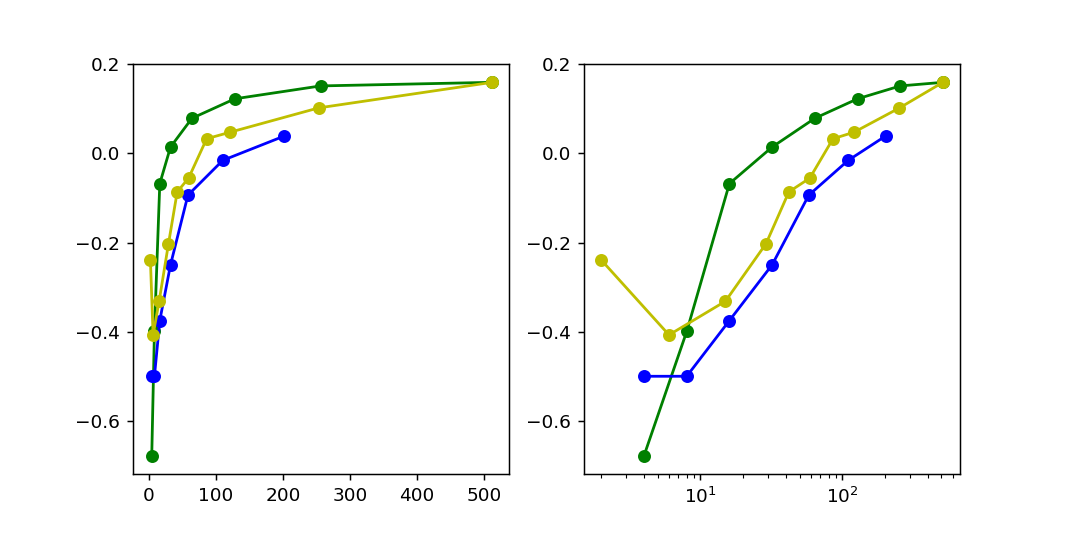

Iteration:  1 	Target:  256
Iteration:  2 	Target:  128
Iteration:  3 	Target:  64
Iteration:  4 	Target:  32
Iteration:  5 	Target:  16
Iteration:  6 	Target:  8
Iteration:  7 	Target:  4
Doing DM (this might take some time, doing all steps before plotting)
(10, 512)
0 512 0.159460991704
1 253 0.102068423076
2 121 0.0475903112651
3 86 0.0329173539886
4 59 -0.055393979692
5 42 -0.0863259787197
6 29 -0.202423182624
7 15 -0.331621211021
8 6 -0.407253823447
9 2 -0.239326135977


In [3]:
# EXPERIMENT
%matplotlib notebook
minimal_margins = []
xs = []
fig, (ax, ax_log) = plt.subplots(1, 2, figsize=(8,4)) 
ax_log.set_xscale('log')

for i in range(2, math.ceil(np.log2(max_hypothesis)), 1):   
    current_hypothesis = 2**i
    ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=depth),  algorithm="SAMME", n_estimators=current_hypothesis)
    ada.fit(X, y)
    
    minimal_margin = Lib.compute_minimal_margin(ada, X, y)
    
    minimal_margins.append(minimal_margin)
    xs.append(current_hypothesis)
    ax.plot(xs, minimal_margins, '-go')
    ax_log.plot(xs, minimal_margins, '-go')
    fig.canvas.draw()
    
hyp_cap = ada.n_estimators

# DOWNSAMPLE 
rev = list(xs)
rev.reverse()
ds_xs= []
ds_minimal_margins = [] # down sampled
dm_xs= []
dm_minimal_margins = [] # discrepancy minimized

for i in range(1, len(rev)):
    current_target = rev[i]
    print("Iteration: ", i, "\tTarget: ", current_target)
    
    # random sample
    rs_ada, minimal_margin = Lib.random_sample(ada, current_target, X, y, repeat=10) # 
    
    ds_minimal_margins.append(minimal_margin)
    ds_xs.append((rs_ada.estimator_weights_ != 0).sum())
    
    ax.cla()
    ax_log.cla()
    ax.plot(xs, minimal_margins, '-go')
    ax.plot(ds_xs, ds_minimal_margins, '-bo')
    ax_log.set_xscale('log')
    ax_log.plot(xs, minimal_margins, '-go')
    ax_log.plot(ds_xs, ds_minimal_margins, '-bo')
    fig.canvas.draw()

print("Doing DM (this might take some time, doing all steps before plotting)")
U, w = Lib.discrepancy_minimization(ada, current_target, X, y)
print(w.shape)
for i in range(w.shape[0]):
    current_minimal_margin = np.min(U @ w[i])
    print(i, sum(w[i] != 0), current_minimal_margin)
    dm_minimal_margins.append(current_minimal_margin)
    dm_xs.append( sum(w[i] != 0))

ax.cla()
ax_log.cla()
ax_log.set_xscale('log')
ax.plot(xs, minimal_margins, '-go')
ax.plot(ds_xs, ds_minimal_margins, '-bo')
ax.plot(dm_xs, dm_minimal_margins, '-yo')                         
ax_log.plot(xs, minimal_margins, '-go')
ax_log.plot(ds_xs, ds_minimal_margins, '-bo')
ax_log.plot(dm_xs, dm_minimal_margins, '-yo')
fig.canvas.draw()


# add a log scale plot

# Minimal Margin Test (with validation error)

<IPython.core.display.Javascript object>


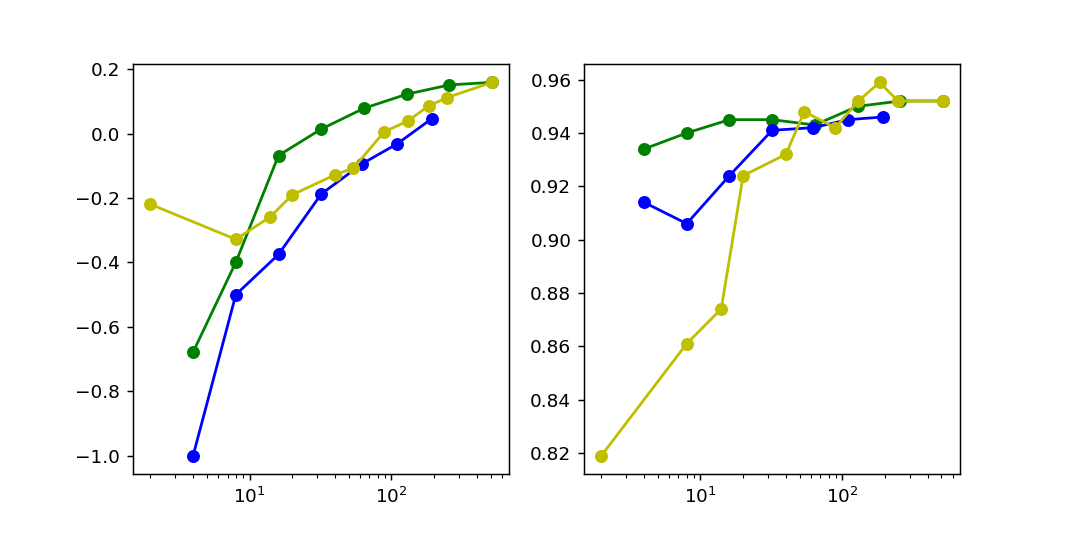

Iteration:  1 	Target:  256
Iteration:  2 	Target:  128
Iteration:  3 	Target:  64
Iteration:  4 	Target:  32
Iteration:  5 	Target:  16
Iteration:  6 	Target:  8
Iteration:  7 	Target:  4
Doing DM (this might take some time, doing all steps before plotting)
(11, 512)
0 512 0.159460991704
1 247 0.112141680954
2 183 0.0860421284283
3 130 0.0390026285879
4 89 0.00576009431638
5 54 -0.106851594829
6 40 -0.12781805901
7 20 -0.189903309503
8 14 -0.258293965247
9 8 -0.328148284122
10 2 -0.219398656732


In [4]:
# EXPERIMENT
%matplotlib notebook
minimal_margins = []
accs = []
xs = []
fig, (ax_margin, ax_val) = plt.subplots(1, 2, figsize=(8,4)) 

ax_margin.set_xscale('log')
ax_val.set_xscale('log')

for i in range(2, math.ceil(np.log2(max_hypothesis)), 1):   
    current_hypothesis = 2**i
    
    ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=depth),  algorithm="SAMME", n_estimators=current_hypothesis)
    ada.fit(X, y)
    
    minimal_margin = Lib.compute_minimal_margin(ada, X, y)    
    
    minimal_margins.append(minimal_margin)
    accs.append(ada.score(X_val, y_val))
    
    xs.append(current_hypothesis)
    ax_margin.plot(xs, minimal_margins, '-go')
    ax_val.plot(xs, accs, '-go')
    fig.canvas.draw()
    
hyp_cap = ada.n_estimators

# DOWNSAMPLE 
rev = list(xs)
rev.reverse()
ds_xs= []
ds_minimal_margins = [] # down sampled
ds_accs = []
dm_xs= []
dm_minimal_margins = [] # discrepancy minimized
dm_accs = []

for i in range(1, len(rev)):
    current_target = rev[i]
    print("Iteration: ", i, "\tTarget: ", current_target)
    
    # random sample
    rs_ada, minimal_margin = Lib.random_sample(ada, current_target, X, y, repeat=10) # 
    
    ds_accs.append(rs_ada.score(X_val, y_val))
    ds_minimal_margins.append(minimal_margin)
    ds_xs.append((rs_ada.estimator_weights_ != 0).sum())
    
    ax_margin.cla()
    ax_val.cla()
    
    ax_margin.set_xscale('log')
    ax_val.set_xscale('log')
    
    ax_margin.plot(xs, minimal_margins, '-go')
    ax_margin.plot(ds_xs, ds_minimal_margins, '-bo')
    
    ax_val.plot(xs, accs, '-go')
    ax_val.plot(ds_xs, ds_accs, '-bo')
    fig.canvas.draw()

print("Doing DM (this might take some time, doing all steps before plotting)")
U, w = Lib.discrepancy_minimization(ada, current_target, X, y)
print(w.shape)
for i in range(w.shape[0]):
    
    current_minimal_margin = np.min(U @ w[i])
    print(i, sum(w[i] != 0), current_minimal_margin)
    dm_minimal_margins.append(current_minimal_margin)
    dm_xs.append( sum(w[i] != 0))
    
    current_ada = copy.deepcopy(ada)
    ada.estimator_weights_ = w[i]
    dm_accs.append(current_ada.score(X_val, y_val))

ax_margin.cla()
ax_val.cla()

ax_margin.set_xscale('log')
ax_val.set_xscale('log')

ax_margin.plot(xs, minimal_margins, '-go')
ax_margin.plot(ds_xs, ds_minimal_margins, '-bo')
ax_margin.plot(dm_xs, dm_minimal_margins, '-yo')  

ax_val.plot(xs, accs, '-go')
ax_val.plot(ds_xs, ds_accs, '-bo')
ax_val.plot(dm_xs, dm_accs, '-yo')
fig.canvas.draw()

# add a log scale plot

# Minimal Margin (use more data but RS + DM)

Do above experiment with $n=100 000$, then DiscMin will be too slow. Fix this by sampling points to get $U$ matrix and repeat this several times. 


<b>Question: </b> Would this test make sense?

# (Ada+DM) Boost
Train directly to 100 hypothesis

<IPython.core.display.Javascript object>


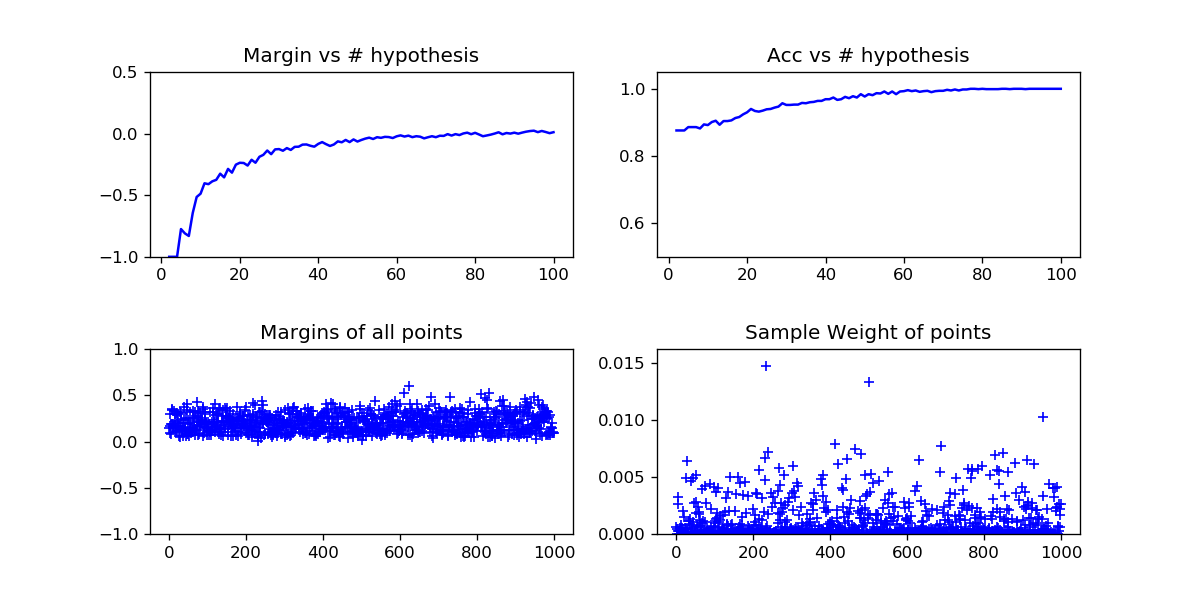

--------------------------------------------------------------------------------
Direct: 		 0.00535935004855
DM minimal margin: 	  -0.101443837299  (48)


<IPython.core.display.Javascript object>


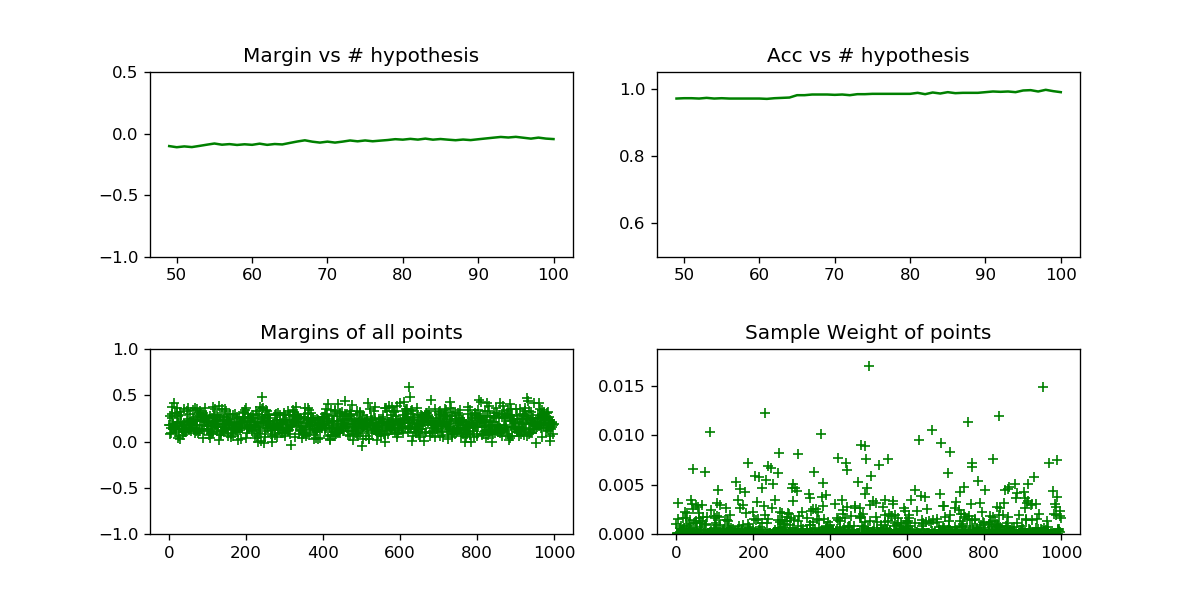

Direct: 		 0.00535935004855
DM 48 -> 100 : 	 -0.0492928795569
--------------------------------------------------------------------------------


In [1]:
%matplotlib notebook

# Boosting source code
# https://github.com/scikit-learn/scikit-learn/blob/f3320a6f/sklearn/ensemble/weight_boosting.py#L387
from sklearn.tree.tree import BaseDecisionTree
from sklearn.utils import check_random_state
import copy
import time

##
import numpy as np
from sklearn.datasets import make_classification
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import Lib
import math
import copy

import sparsipy

# GENERATE DATA 
n = 1000 # do 1000 for fast run, takes no more than a few mins. 
d = 50  
depth = 2
max_hypothesis = 2**9+1
step = 100

X, y = make_classification(n*2, d, n_classes=2)
y = y*2-1

X_val = X[:n]
y_val = y[:n]
X = X[n: ]
y = y[n: ]

assert X_val.shape == (n, d)
assert y_val.shape == (n, )
assert X.shape == (n, d), X.shape
assert y.shape== (n,)
assert set(y) == {-1, +1}
##



def discrepancy_minimization(ada, target, X, y):
    U, _, _ = compute_matrix(ada, X, y)
    return U, sparsipy.sparsify(U, ada.estimator_weights_, target)

def compute_margins(ada, X, y):
    '''
    computes normalized margins, e.g. normalizes hypothesis weights
    so they sum to 1
    
    Contract: 
    doesn't change mutate ada, X or y. 
    '''
    y = np.copy(y) 
    ada = copy.deepcopy(ada)
    ada.estimator_weights_ /= np.sum(ada.estimator_weights_)
    
    # if {0, 1} change to {-1, 1}
    if set(y) != {-1, +1} and set(y) == {0, 1}: y = y*2-1
    assert set(y) == {-1, +1}, ("Labels are not {-1, +1} but: ", set(y))
    
    H = ada.decision_function(X)
    margins = H * y
    
    return margins
 
def compute_minimal_margin(ada, X, y): 
    return np.min(compute_margins(ada, X, y))

def compute_matrix(ada, X, y):
    '''
        Assumes 
            ada.classes_ = np.array([-1, 1])
        That is, the classes are represented with {-1, +1}. Similarly we assume
        the labels are of the form {-1, +1}. 
        
        Contract: 
            Doesn't change/mutate ada, X or y
    '''
    n, d = np.shape(X)
    
    ada = copy.deepcopy(ada)
    y = copy.deepcopy(y)
    
    # if {0, 1} change to {-1, +1}
    if set(y) != {-1, +1} and set(y) == {0, 1}: 
        print("WARNING: y was not originally {-1, +1} but ", set(y))
        y = y*2-1
    assert set(y) == {-1, +1}, ("Labels are not {-1, +1} but: ", set(y))
    
    estimators = ada.estimators_
    w = ada.estimator_weights_
    
    T   = len(ada.estimators_)
    T_w = ada.estimator_weights_.shape[0]
    assert T == T_w, (T, T_w)
    
    U = np.zeros((n, T))                    # final game matrix
    
    # Normalize weights 
    #w = w / np.sum(w)
    #assert np.allclose(np.sum(w), 1), np.sum(w)
    
    # Add a column to U for each hypothesis with non-zero weight
    for t in range(len(estimators)):
        h = ada.estimators_[t]
        pred = h.predict(X)        
        assert set(pred) == {-1, +1}        # make sure predictions are +-1
        U[:,t] = pred * y                   # * is entry wise multiplication.
    
    # make sure U has the right entries. 
    assert np.allclose(np.unique(U), np.array([-1, +1])), np.unique(U)
        
    # Compute margins using U and w
    margins1 = U @ w / np.sum(w)
    
    # Compute margins using sklearn. .
    H = ada.decision_function(X)
    margins2 = H * y
    
    # Sanity check
    assert np.allclose(margins1, margins2), (margins1, margins2)
    
    return U, w, np.min(margins1)


def step(steps, ada, X, y, sample_weight, color='g', assertions=True): 
    n, d = X.shape
    
    fig, axs = plt.subplots(2, 2, figsize=(10,5)) 
    fig.subplots_adjust(hspace=.5)
    ax_margin_plot, ax_acc = axs[0]
    ax_margins, ax_sample_weights = axs[1]
   
    lst_margins = []
    lst_accs = []
    lst_Ts = []
    
    initial_count = (ada.estimator_weights_ != 0).sum() # potential off by one?
    recompute_sample_weights = np.ones(n) / n
    
    for iboost in range(steps):
        
        assert np.allclose(np.sum(recompute_sample_weights), 1.0), np.sum(recompute_sample_weights)
        assert np.allclose(np.sum(sample_weight), 1.0), np.sum(sample_weight)
        
        real_i = initial_count + iboost
        
        #print(real_i, iboost)
        
        if real_i > 0: 
                
            margins = compute_margins(ada, X, y)
            lst_margins.append(np.min(margins))
            lst_accs.append(ada.score(X, y))
            lst_Ts.append(real_i + 1)
            
            # plot exponential guys besides this. 
            ax_margin_plot.cla()
            ax_acc.cla()
            ax_margins.cla()
            ax_sample_weights.cla()
            
            ax_margins.set_ylim([-1, 1])
            ax_margin_plot.set_ylim([-1, 0.5])
            ax_acc.set_ylim([0.5, 1.05])
            ax_sample_weights.set_ylim([0, np.max(sample_weight)*1.1])
            
            ax_margin_plot.set_title("Margin vs # hypothesis")
            ax_acc.set_title("Acc vs # hypothesis")
            ax_margins.set_title("Margins of all points")
            ax_sample_weights.set_title("Sample Weight of points")
            
            ax_margin_plot.plot(lst_Ts, lst_margins, "-" + color)
            ax_acc.plot(lst_Ts, lst_accs, "-" + color)
            
            ax_margins.plot(margins, color + "+")
            ax_sample_weights.plot(sample_weight, color + "+")
            
            fig.canvas.draw()
        
        
        # test computation of sample_weights
        '''if real_i > 2: 

            I = np.array([y != est.predict(X) for est in ada.estimators_])
            assert np.shape(I) == (len(ada.estimators_), n), np.shape(I)
            
            recompute_sample_weights = np.exp( I.T @ ada.estimator_weights_[ada.estimator_weights_ != 0])
            
            assert np.shape(recompute_sample_weights) == (n, )
            
            recompute_sample_weights = recompute_sample_weights / np.sum(recompute_sample_weights)
            
            if assertions: 
                
                assert np.allclose(recompute_sample_weights, sample_weight)
            else:
                #time.sleep(2)
                pass'''
                
 
        # Boosting step
        sample_weight, estimator_weight, estimator_error = ada._boost(
            real_i,
            X, y,
            sample_weight,
            random_state)
        
        # Initialized to 0 and 1 respectively. 
        assert np.allclose(ada.estimator_weights_[real_i], 0),  ada.estimator_weights_[real_i]
        assert np.allclose(ada.estimator_errors_[real_i], 1.0), ada.estimator_errors_[real_i]
        
        ada.estimator_weights_[real_i] = estimator_weight
        ada.estimator_errors_[real_i] = estimator_error

        sample_weight_sum = np.sum(sample_weight)
        sample_weight /= sample_weight_sum
    
    non_zero_weights = (ada.estimator_weights_ != 0).sum()
    mm = compute_minimal_margin(ada, X, y)
    _, _, mm2 = compute_matrix(ada, X, y)
    
    assert np.allclose(mm, mm2), (mm, mm2)
    
    return ada, sample_weight, mm

def step_to(target, ada, X, y, sample_weight, color='g', assertions=True):
    T = (ada.estimator_weights_!=0).sum()
    steps = target - T 
    ada, sample_weight, mm = step(steps, ada, X, y, sample_weight, color=color, assertions=assertions)
    return ada, sample_weight, mm

# mistakes:
# re-normalization of weights after discrepancy minimization
# computation of margins with y\in{0, 1} and not {-1, +1}
n, d = X.shape
T = 100
depth = 2

assert set(y) == {-1, +1}

ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=depth),  algorithm="SAMME", n_estimators=T)
ada.base_estimator_ = ada.base_estimator
ada.classes_ = np.array([-1, 1])
ada.n_classes_ = len(ada.classes_)

ada.estimators_ = []
ada.estimator_weights_ = np.zeros(ada.n_estimators, dtype=np.float64)
ada.estimator_errors_  = np.ones(ada.n_estimators, dtype=np.float64)

random_state = check_random_state(np.random.RandomState(42))

 # Initialize weights to 1 / n_samples
sample_weight = np.empty(X.shape[0], dtype=np.float64)
sample_weight[:] = 1. / X.shape[0]
    
#ada.fit(X, y)
ada, sample_weight, mm_direct = step_to(T, ada, X, y, sample_weight, color='b')

U, w, mm = compute_matrix(ada, X, y)
mm1 = compute_minimal_margin(ada, X, y)
assert np.allclose(mm, mm1)

normalization_factor = np.sum(ada.estimator_weights_)
ada.estimator_weights_ = ada.estimator_weights_ / normalization_factor

U, w, mm = compute_matrix(ada, X, y)
assert np.allclose(mm, mm1)
mm1 = compute_minimal_margin(ada, X, y)
assert np.allclose(mm, mm1) 
assert np.allclose(mm, mm_direct)
# checks normalization doesn't change minimal margin


# normalize weights first
#ada.estimator_weights_ = ada.estimator_weights_ / np.sum(ada.estimator_weights_)
#assert np.allclose(np.sum(ada.estimator_weights_),  1) # test removing this; does disc min still work?

U, w = discrepancy_minimization(ada, 4, X, y)
assert U.shape == (n, T)


i = 1

print("--------------------------------------------------------------------------------")
print("Direct: \t\t", mm_direct)

# train up from w[i] -> 100 using Step To and compare minimal margin with 
# what we got from training directly. 

w[i] = w[i] / np.sum(w[i]) # normalize new weights.

DM_mm = np.min(U @ w[i])
non_zero = (w[i] != 0).sum()
print("DM minimal margin: \t ", DM_mm, " (%i)"%non_zero)

ada_i = copy.deepcopy(ada)
ada_i.estimator_weights_ = w[i]  

ada_i_mm1 = compute_minimal_margin(ada_i, X, y)
#print("Ada MM with DM weights (1): \t", ada_i_mm1)  

# sort weights and estimators to make it easier to remove zero weighed estimators. 
lists = []
for j in range(w[i].shape[0]):
    lists.append( (w[i][j], ada_i.estimators_[j], ada_i.estimator_errors_[j])  )
lists = sorted(lists, key = lambda x: x[0], reverse=True)

# add estiamtors with positive weight
ada_i.estimators_ = [tupple[1] for tupple in lists if tupple[0] > 0.0] # add only estimators with > 0 weight

# initialize weights and errors as 0 and 1 as with initial adaboost,
# then we can update the non-zero / non-one entries. 
ada_i.estimator_weights_ = np.zeros(T, dtype=np.float64)
ada_i.estimator_errors_  = np.ones(T, dtype=np.float64)

ada_i.estimator_weights_[:non_zero] = np.array([tupple[0] for tupple in lists if tupple[0] > 0.0])
ada_i.estimator_errors_[:non_zero]  = np.array([tupple[2] for tupple in lists if tupple[0] > 0.0])

assert ada.estimator_weights_.shape == (T, )
assert ada.estimator_errors_.shape == (T, )

ada_i.estimator_weights_ *= normalization_factor # TODO: explain, also try remove normalization both places.

# Check that minimal margins are the same when computing using matrix U and weights 'w'
# and after we inject/sort weights into the ada object.
ada_i_mm2 = compute_minimal_margin(ada_i, X, y)
#print("Ada MM with DM weights (2): \t", ada_i_mm2)
assert np.allclose(DM_mm, ada_i_mm1), (DM_mm, ada_i_mm1)
assert np.allclose(DM_mm, ada_i_mm2), (DM_mm, ada_i_mm2)

# compute a sample weight. 
margins = compute_margins(ada_i, X, y)
recompute_sample_weights = np.exp(-margins)
recompute_sample_weights = recompute_sample_weights / np.sum(recompute_sample_weights)

ada_i, _, mm_new = step_to(T, ada_i, X, y, sample_weight, assertions=False) 

print("Direct: \t\t", mm_direct)
print("DM %i -> %i"%(non_zero, T), ": \t", mm_new)

print("--------------------------------------------------------------------------------")




# Try above experiment for larger values

 99.5 	 0.085                    
Direct: 		 0.0844020376404


<IPython.core.display.Javascript object>


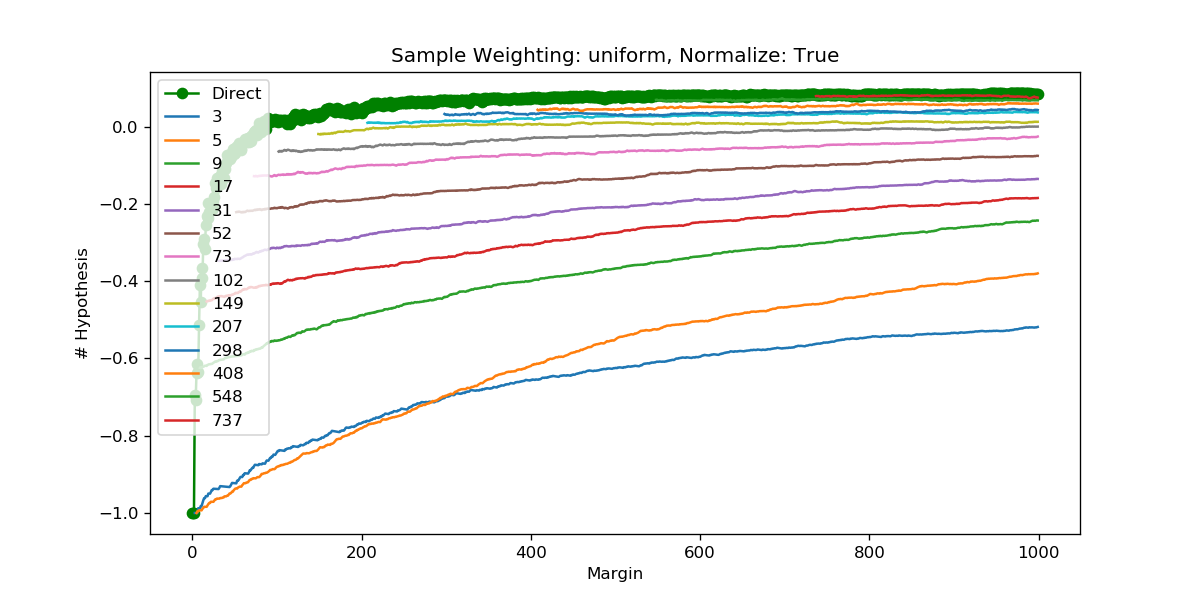

--------------------------------------------------------------------------------
DM 3 minimal margin: 	 -1.0
Drect 3 margin: 	 -0.693546484518
 99.8 	 -0.5192                    
DM 3 -> 1000: 		 -0.518503506924
--------------------------------------------------------------------------------
DM 5 minimal margin: 	 -1.0
Drect 5 margin: 	 -0.638177530788
 99.5 	 -0.3814                    
DM 5 -> 1000: 		 -0.379848267294
--------------------------------------------------------------------------------
DM 9 minimal margin: 	 -0.626889283709
Drect 9 margin: 	 -0.410807386195
 99.9 	 -0.243                     
DM 9 -> 1000: 		 -0.243044836089
--------------------------------------------------------------------------------
DM 17 minimal margin: 	 -0.45215676817
Drect 17 margin: 	 -0.231810331552
 99.69 	 -0.1849                   
DM 17 -> 1000: 		 -0.184786796849
--------------------------------------------------------------------------------
DM 31 minimal margin: 	 -0.347953084315
Drect 3

<IPython.core.display.Javascript object>


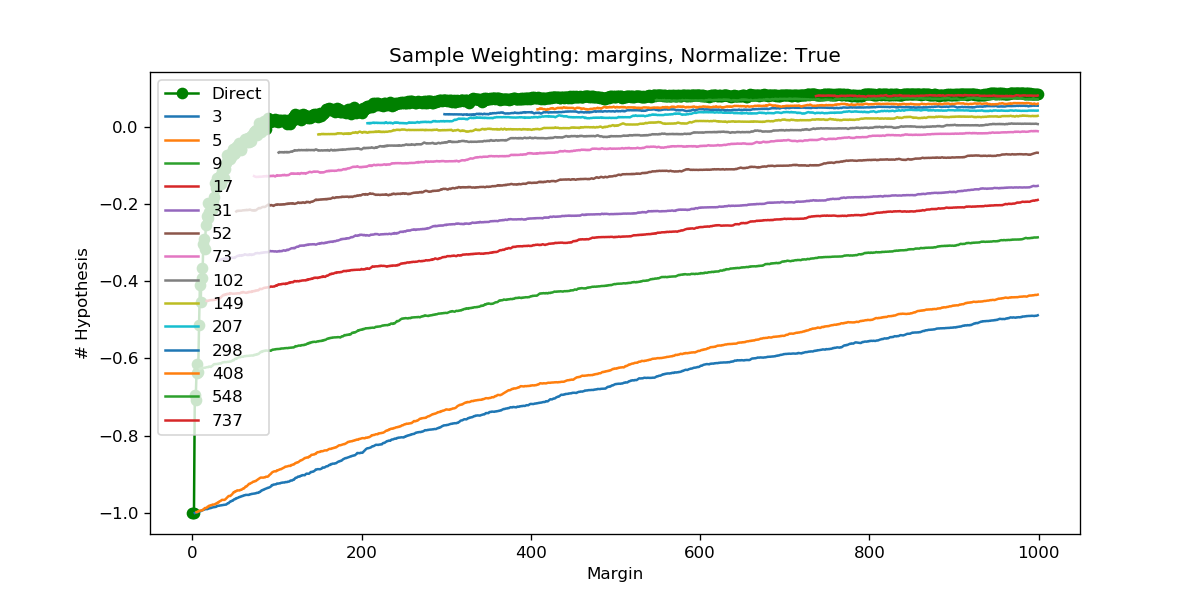

--------------------------------------------------------------------------------
DM 3 minimal margin: 	 -1.0
Drect 3 margin: 	 -0.693546484518
 99.8 	 -0.4892                    
DM 3 -> 1000: 		 -0.48828295202
--------------------------------------------------------------------------------
DM 5 minimal margin: 	 -1.0
Drect 5 margin: 	 -0.638177530788
 99.5 	 -0.4362                    
DM 5 -> 1000: 		 -0.434859497397
--------------------------------------------------------------------------------
DM 9 minimal margin: 	 -0.626889283709
Drect 9 margin: 	 -0.410807386195
 99.9 	 -0.2866                    
DM 9 -> 1000: 		 -0.286612956677
--------------------------------------------------------------------------------
DM 17 minimal margin: 	 -0.45215676817
Drect 17 margin: 	 -0.231810331552
 99.69 	 -0.1902                   
DM 17 -> 1000: 		 -0.189725950032
--------------------------------------------------------------------------------
DM 31 minimal margin: 	 -0.347953084315
Drect 31

<IPython.core.display.Javascript object>


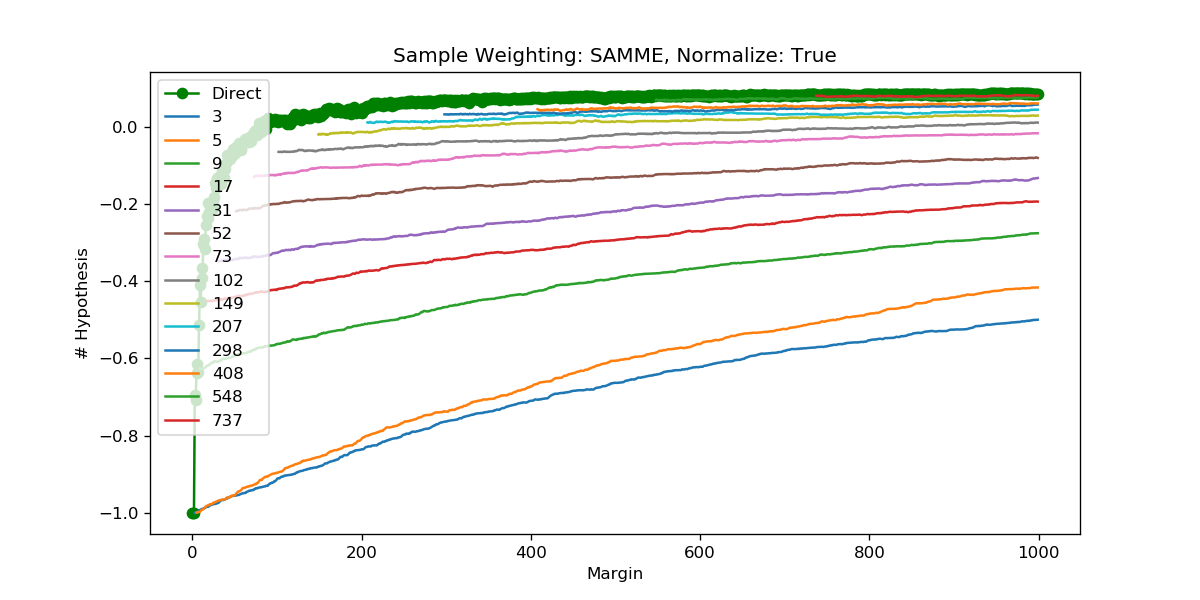

--------------------------------------------------------------------------------
DM 3 minimal margin: 	 -1.0
Drect 3 margin: 	 -0.693546484518
 99.8 	 -0.5002                    
DM 3 -> 1000: 		 -0.499724765733
--------------------------------------------------------------------------------
DM 5 minimal margin: 	 -1.0
Drect 5 margin: 	 -0.638177530788
 99.5 	 -0.4168                    
DM 5 -> 1000: 		 -0.416404071683
--------------------------------------------------------------------------------
DM 9 minimal margin: 	 -0.626889283709
Drect 9 margin: 	 -0.410807386195
 99.9 	 -0.2759                    
DM 9 -> 1000: 		 -0.275891951118
--------------------------------------------------------------------------------
DM 17 minimal margin: 	 -0.45215676817
Drect 17 margin: 	 -0.231810331552
 99.69 	 -0.1941                   
DM 17 -> 1000: 		 -0.194106709801
--------------------------------------------------------------------------------
DM 31 minimal margin: 	 -0.347953084315
Drect 3

<IPython.core.display.Javascript object>


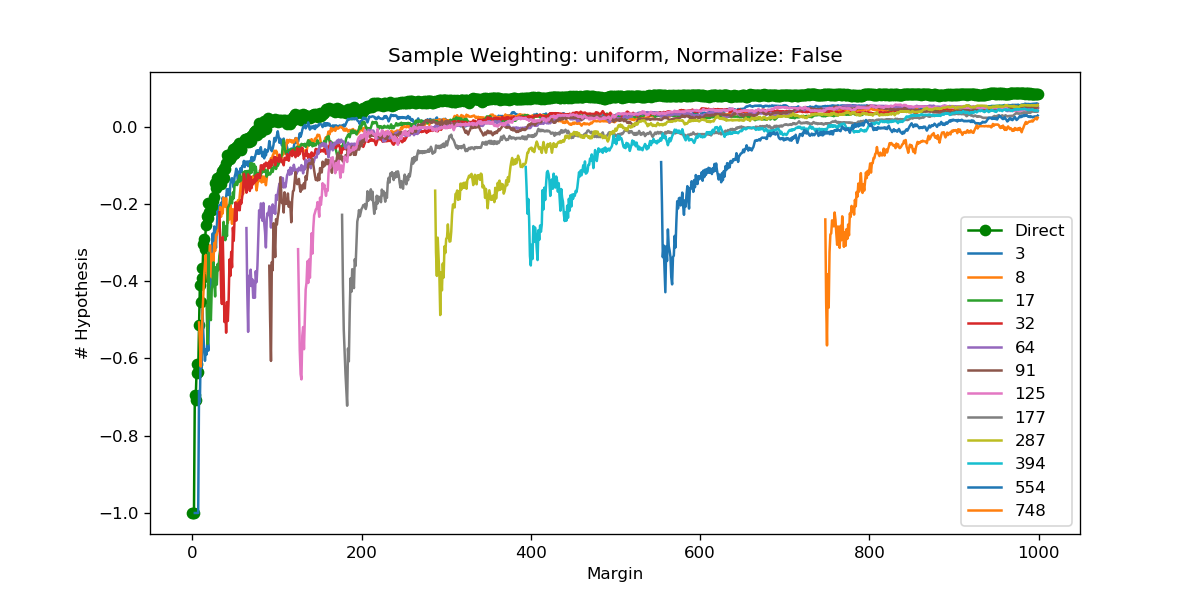

--------------------------------------------------------------------------------
DM 3 minimal margin: 	 -1.0
Drect 3 margin: 	 -0.693546484518
 99.8 	 0.0601                     
DM 3 -> 1000: 		 0.0591289192522
--------------------------------------------------------------------------------
DM 8 minimal margin: 	 -0.351016699765
Drect 8 margin: 	 -0.514681144132
 99.8 	 0.0549                     23.69 	 -0.0165                   
DM 8 -> 1000: 		 0.0561202279012
--------------------------------------------------------------------------------
DM 17 minimal margin: 	 -0.241380297675
Drect 17 margin: 	 -0.231810331552
 99.69 	 0.0518                    -0.0966                   	 -0.0015                   
DM 17 -> 1000: 		 0.0517782210469
--------------------------------------------------------------------------------
DM 32 minimal margin: 	 -0.137802918975
Drect 32 margin: 	 -0.14982328934
 99.69 	 0.0507                    
DM 32 -> 1000: 		 0.050170031203
---------------------------

<IPython.core.display.Javascript object>


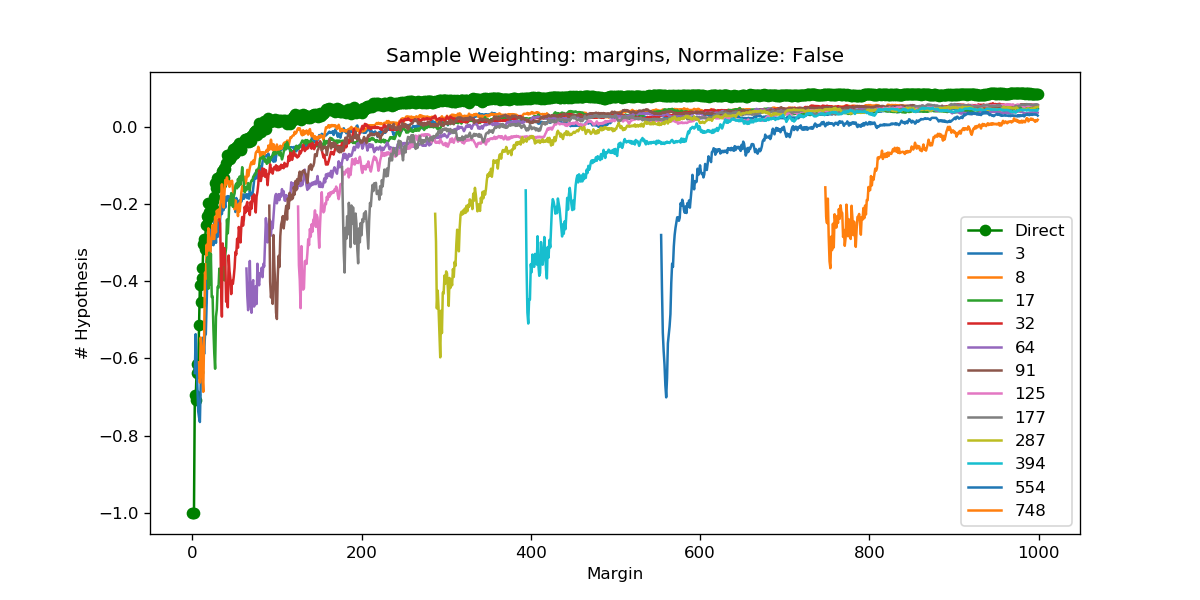

--------------------------------------------------------------------------------
DM 3 minimal margin: 	 -1.0
Drect 3 margin: 	 -0.693546484518
 99.8 	 0.0484                     
DM 3 -> 1000: 		 0.0463149200583
--------------------------------------------------------------------------------
DM 8 minimal margin: 	 -0.351016699765
Drect 8 margin: 	 -0.514681144132
 99.8 	 0.0512                     
DM 8 -> 1000: 		 0.0505996468908
--------------------------------------------------------------------------------
DM 17 minimal margin: 	 -0.241380297675
Drect 17 margin: 	 -0.231810331552
 99.69 	 0.0481                    
DM 17 -> 1000: 		 0.0481304923288
--------------------------------------------------------------------------------
DM 32 minimal margin: 	 -0.137802918975
Drect 32 margin: 	 -0.14982328934
 99.69 	 0.0558                    
DM 32 -> 1000: 		 0.0532820629601
--------------------------------------------------------------------------------
DM 64 minimal margin: 	 -0.091405

<IPython.core.display.Javascript object>


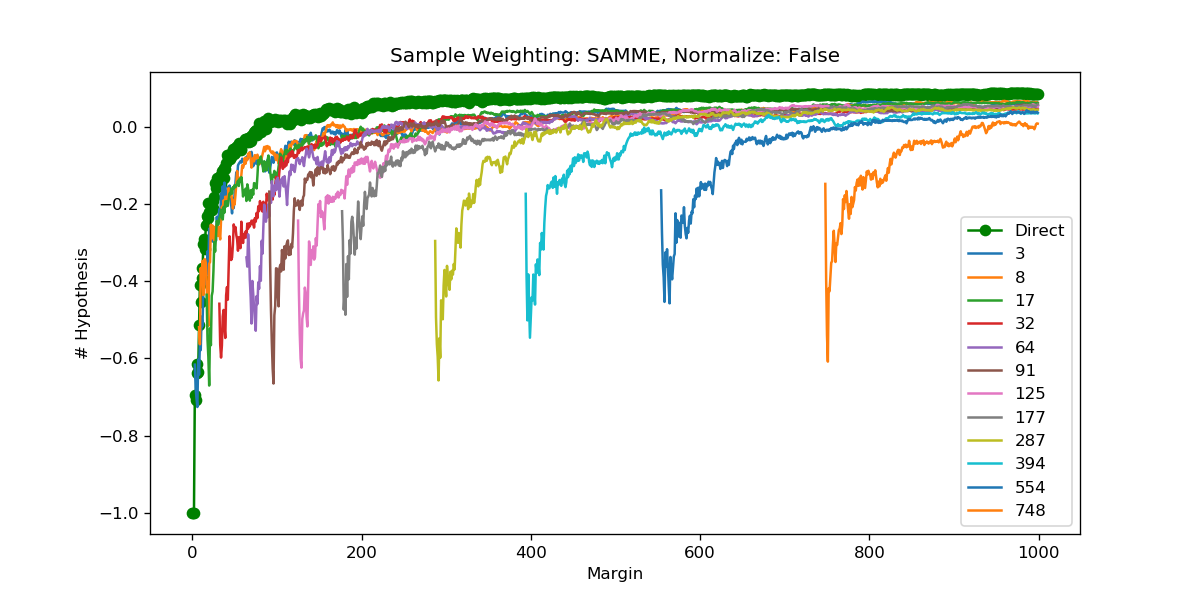

--------------------------------------------------------------------------------
DM 3 minimal margin: 	 -1.0
Drect 3 margin: 	 -0.693546484518
 99.8 	 0.0541                      	 -0.0178                   
DM 3 -> 1000: 		 0.0550602210397
--------------------------------------------------------------------------------
DM 8 minimal margin: 	 -0.351016699765
Drect 8 margin: 	 -0.514681144132
 99.8 	 0.0632                     
DM 8 -> 1000: 		 0.0620214911989
--------------------------------------------------------------------------------
DM 17 minimal margin: 	 -0.241380297675
Drect 17 margin: 	 -0.231810331552
 99.69 	 0.0613                    22.38 	 -0.0133                   
DM 17 -> 1000: 		 0.0612266213894
--------------------------------------------------------------------------------
DM 32 minimal margin: 	 -0.137802918975
Drect 32 margin: 	 -0.14982328934
 99.69 	 0.0451                    
DM 32 -> 1000: 		 0.0451113939888
---------------------------------------------------

In [26]:
%matplotlib notebook

# Boosting source code
# https://github.com/scikit-learn/scikit-learn/blob/f3320a6f/sklearn/ensemble/weight_boosting.py#L387
from sklearn.tree.tree import BaseDecisionTree
from sklearn.utils import check_random_state
import copy
import time

##
import numpy as np
from sklearn.datasets import make_classification
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import Lib
import math
import copy

import sparsipy

# GENERATE DATA 
n = 1000 # do 1000 for fast run, takes no more than a few mins. 
d = 20  
depth = 2
step = 100

X, y = make_classification(n*2, d, n_classes=2)
y = y*2-1

X_val = X[:n]
y_val = y[:n]
X = X[n: ]
y = y[n: ]

assert X_val.shape == (n, d)
assert y_val.shape == (n, )
assert X.shape == (n, d), X.shape
assert y.shape== (n,)
assert set(y) == {-1, +1}
##



def discrepancy_minimization(ada, target, X, y):
    U, _, _ = compute_matrix(ada, X, y)
    return U, sparsipy.sparsify(U, ada.estimator_weights_, target)

def compute_margins(ada, X, y):
    '''
    computes normalized margins, e.g. normalizes hypothesis weights
    so they sum to 1
    
    Contract: 
    doesn't change mutate ada, X or y. 
    '''
    y = np.copy(y) 
    ada = copy.deepcopy(ada)
    ada.estimator_weights_ /= np.sum(ada.estimator_weights_)
    
    # if {0, 1} change to {-1, 1}
    if set(y) != {-1, +1} and set(y) == {0, 1}: y = y*2-1
    assert set(y) == {-1, +1}, ("Labels are not {-1, +1} but: ", set(y))
    
    H = ada.decision_function(X)
    margins = H * y
    
    return margins
 
def compute_minimal_margin(ada, X, y): 
    return np.min(compute_margins(ada, X, y))

def compute_matrix(ada, X, y):
    '''
        Assumes 
            ada.classes_ = np.array([-1, 1])
        That is, the classes are represented with {-1, +1}. Similarly we assume
        the labels are of the form {-1, +1}. 
        
        Contract: 
            Doesn't change/mutate ada, X or y
    '''
    n, d = np.shape(X)
    
    ada = copy.deepcopy(ada)
    y = copy.deepcopy(y)
    
    # if {0, 1} change to {-1, +1}
    if set(y) != {-1, +1} and set(y) == {0, 1}: 
        print("WARNING: y was not originally {-1, +1} but ", set(y))
        y = y*2-1
    assert set(y) == {-1, +1}, ("Labels are not {-1, +1} but: ", set(y))
    
    estimators = ada.estimators_
    w = ada.estimator_weights_
    
    T   = len(ada.estimators_)
    T_w = ada.estimator_weights_.shape[0]
    assert T == T_w, (T, T_w)
    
    U = np.zeros((n, T))                    # final game matrix
    
    # Normalize weights 
    #w = w / np.sum(w)
    #assert np.allclose(np.sum(w), 1), np.sum(w)
    
    # Add a column to U for each hypothesis with non-zero weight
    for t in range(len(estimators)):
        h = ada.estimators_[t]
        pred = h.predict(X)        
        assert set(pred).issubset({-1, +1}), set(pred)    # make sure predictions are +-1
        U[:,t] = pred * y                   # * is entry wise multiplication.
    
    # make sure U has the right entries. 
    assert np.allclose(np.unique(U), np.array([-1, +1])), np.unique(U)
        
    # Compute margins using U and w
    margins1 = U @ w / np.sum(w)
    
    # Compute margins using sklearn. .
    H = ada.decision_function(X)
    margins2 = H * y
    
    # Sanity check
    assert np.allclose(margins1, margins2), (margins1, margins2)
    
    return U, w, np.min(margins1)


def step(steps, ada, X, y, sample_weight, color='g', assertions=True, plot=False): 
    n, d = X.shape
    
    if plot: 
        fig, axs = plt.subplots(2, 2, figsize=(10,5)) 
        fig.subplots_adjust(hspace=.5)
        ax_margin_plot, ax_acc = axs[0]
        ax_margins, ax_sample_weights = axs[1]

        lst_accs = []
        lst_Ts = []
    
    lst_margins = []
    
    initial_count = (ada.estimator_weights_ != 0).sum() # potential off by one?
    recompute_sample_weights = np.ones(n) / n
    
    for iboost in range(steps):
        
        assert np.allclose(np.sum(recompute_sample_weights), 1.0), np.sum(recompute_sample_weights)
        assert np.allclose(np.sum(sample_weight), 1.0), np.sum(sample_weight)
        
        real_i = initial_count + iboost
        
        #print(real_i, iboost)
        
        if real_i > 0 and plot: 
                
           
            lst_accs.append(ada.score(X, y))
            lst_Ts.append(real_i + 1)
            
            # plot exponential guys besides this. 
            ax_margin_plot.cla()
            ax_acc.cla()
            ax_margins.cla()
            ax_sample_weights.cla()
            
            ax_margins.set_ylim([-1, 1])
            ax_margin_plot.set_ylim([-1, 0.5])
            ax_acc.set_ylim([0.5, 1.05])
            ax_sample_weights.set_ylim([0, np.max(sample_weight)*1.1])
            
            ax_margin_plot.set_title("Margin vs # hypothesis")
            ax_acc.set_title("Acc vs # hypothesis")
            ax_margins.set_title("Margins of all points")
            ax_sample_weights.set_title("Sample Weight of points")
            
            ax_margin_plot.plot(lst_Ts, lst_margins, "-" + color)
            ax_acc.plot(lst_Ts, lst_accs, "-" + color)
            
            ax_margins.plot(margins, color + "+")
            ax_sample_weights.plot(sample_weight, color + "+")
            
            fig.canvas.draw()            
 
        # Boosting step
        sample_weight, estimator_weight, estimator_error = ada._boost(
            real_i,
            X, y,
            sample_weight,
            random_state)
        
        # Initialized to 0 and 1 respectively. 
        assert np.allclose(ada.estimator_weights_[real_i], 0),  ada.estimator_weights_[real_i]
        assert np.allclose(ada.estimator_errors_[real_i], 1.0), ada.estimator_errors_[real_i]
        
        ada.estimator_weights_[real_i] = estimator_weight
        ada.estimator_errors_[real_i] = estimator_error

        sample_weight_sum = np.sum(sample_weight)
        sample_weight /= sample_weight_sum
        
        margins = compute_margins(ada, X, y)
        lst_margins.append(np.min(margins))
        
        if iboost % 5 == 0: 
            print("\r", round(iboost / steps*100, 2) , "\t", round(lst_margins[iboost], 4), "                  ", end='')
    
    print("") # newline
    non_zero_weights = (ada.estimator_weights_ != 0).sum()
    mm = compute_minimal_margin(ada, X, y)
    _, _, mm2 = compute_matrix(ada, X, y)
    
    assert np.allclose(mm, mm2), (mm, mm2)
    
    return ada, sample_weight, lst_margins

def step_to(target, ada, X, y, sample_weight, color='g', assertions=True):
    T = (ada.estimator_weights_!=0).sum()
    steps = target - T 
    ada, sample_weight, lst_margins = step(steps, ada, X, y, sample_weight, color=color, assertions=assertions)
    return ada, sample_weight, lst_margins

def train_initial_ada(): 
    ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=depth),  algorithm="SAMME", n_estimators=T)
    ada.base_estimator_ = ada.base_estimator
    ada.classes_ = np.array([-1, 1])
    ada.n_classes_ = len(ada.classes_)

    ada.estimators_ = []
    ada.estimator_weights_ = np.zeros(ada.n_estimators, dtype=np.float64)
    ada.estimator_errors_  = np.ones(ada.n_estimators, dtype=np.float64)

    random_state = check_random_state(np.random.RandomState(42))

     # Initialize weights to 1 / n_samples
    sample_weight = np.empty(X.shape[0], dtype=np.float64)
    sample_weight[:] = 1. / X.shape[0]

    #ada.fit(X, y)
    ada, sample_weight, lst_margins = step_to(T, ada, X, y, sample_weight, color='b')
    
    U, w, mm = compute_matrix(ada, X, y)
    mm1 = compute_minimal_margin(ada, X, y)
    assert np.allclose(mm, mm1)

    U, w, mm = compute_matrix(ada, X, y)
    assert np.allclose(mm, mm1)
    mm1 = compute_minimal_margin(ada, X, y)
    assert np.allclose(mm, mm1) 
    assert np.allclose(mm, lst_margins[-1])
    # checks normalization doesn't change minimal margin

    U, w = discrepancy_minimization(ada, 4, X, y)
    assert U.shape == (n, T)
    
    #normalize
    normalization_factor = np.sum(ada.estimator_weights_)
    ada.estimator_weights_ = ada.estimator_weights_ / normalization_factor

    U_, w_ = discrepancy_minimization(ada, 4, X, y)
    
    return ada, lst_margins, w, U, w_, U_, normalization_factor
    

def experiment(normalize, sample_weighting, initial_ada): 
    assert set(y) == {-1, +1}
    
    ada, lst_margins, w, U, w_, U_, normalization_factor = initial_ada
    ada = copy.deepcopy(ada)
    if normalize: 
        w = w_
        U = U_

    print("Direct: \t\t", lst_margins[-1])

    lst_margins_dm = []
    xs_dm = []
    fig, ax_margin = plt.subplots(1, 1, figsize=(10,5)) 

    # train up from w[i] -> 100 using Step To and compare minimal margin with 
    # what we got from training directly. 

    for i in range(w.shape[0]-1, 0, -1):
        print("--------------------------------------------------------------------------------")

        w[i] = w[i] / np.sum(w[i]) # normalize new weights.

        DM_mm = np.min(U @ w[i])
        non_zero = (w[i] != 0).sum()
        print("DM %i minimal margin: \t"%non_zero, DM_mm)
        print("Drect %i margin: \t"%non_zero, lst_margins[non_zero])

        ada_i = copy.deepcopy(ada)
        ada_i.estimator_weights_ = w[i]  

        ada_i_mm1 = compute_minimal_margin(ada_i, X, y)
        #print("Ada MM with DM weights (1): \t", ada_i_mm1)  

        # sort weights and estimators to make it easier to remove zero weighed estimators. 
        lists = []
        for j in range(w[i].shape[0]):
            lists.append( (w[i][j], ada_i.estimators_[j], ada_i.estimator_errors_[j])  )
        lists = sorted(lists, key = lambda x: x[0], reverse=True)

        # add estiamtors with positive weight
        ada_i.estimators_ = [tupple[1] for tupple in lists if tupple[0] > 0.0] # add only estimators with > 0 weight

        # initialize weights and errors as 0 and 1 as with initial adaboost,
        # then we can update the non-zero / non-one entries. 
        ada_i.estimator_weights_ = np.zeros(T, dtype=np.float64)
        ada_i.estimator_errors_  = np.ones(T, dtype=np.float64)

        ada_i.estimator_weights_[:non_zero] = np.array([tupple[0] for tupple in lists if tupple[0] > 0.0])
        ada_i.estimator_errors_[:non_zero]  = np.array([tupple[2] for tupple in lists if tupple[0] > 0.0])

        assert ada.estimator_weights_.shape == (T, )
        assert ada.estimator_errors_.shape == (T, )

        if normalize: 
            ada_i.estimator_weights_ *= normalization_factor # TODO: explain, also try remove normalization both places.

        # Check that minimal margins are the same when computing using matrix U and weights 'w'
        # and after we inject/sort weights into the ada object.
        ada_i_mm2 = compute_minimal_margin(ada_i, X, y)
        #print("Ada MM with DM weights (2): \t", ada_i_mm2)
        assert np.allclose(DM_mm, ada_i_mm1), (DM_mm, ada_i_mm1)
        assert np.allclose(DM_mm, ada_i_mm2), (DM_mm, ada_i_mm2)

        # compute initial sample weight. 
        
        if sample_weighting == "margins": 
            margins = compute_margins(ada_i, X, y)
            recompute_sample_weights = np.exp(-margins)
            recompute_sample_weights = recompute_sample_weights / np.sum(recompute_sample_weights)
        elif sample_weighting == "uniform": 
            recompute_sample_weights = np.ones(n)/n
        elif sample_weighting == "SAMME":
            I = np.array([y != est.predict(X) for est in ada.estimators_])
            assert np.shape(I) == (len(ada.estimators_), n), np.shape(I)
            recompute_sample_weights = np.exp( I.T @ ada.estimator_weights_[ada.estimator_weights_ != 0])
            assert np.shape(recompute_sample_weights) == (n, )
            recompute_sample_weights = recompute_sample_weights / np.sum(recompute_sample_weights)
        else:
            assert False, ("Sample Weighting not defined", sample_weighting)
            
            
        ada_i, _, mm_new = step_to(T, ada_i, X, y, sample_weight, assertions=False) 
       
        lst_margins_dm.append(mm_new)
        xs_dm.append([i for i in range(non_zero, T)])
        ax_margin.cla()
        
        handles, labels = ax_margin.get_legend_handles_labels()
        legends = []
        l, = ax_margin.plot(lst_margins, '-go', label="Direct")
        legends.append(l)
        for i in range(len(lst_margins_dm)):
            l, = ax_margin.plot(xs_dm[i], lst_margins_dm[i], label=str(np.min(xs_dm[i])))
            legends.append(l)
        
       
        plt.legend(handles=legends)
        title = "Sample Weighting: " + sample_weighting + ", Normalize: " + str(normalize)
        ax_margin.set_title( title)
        ax_margin.set_xlabel("Margin")
        ax_margin.set_ylabel("# Hypothesis")
        plt.savefig("figures/" + title)
        fig.canvas.draw()


        print("DM %i -> %i: \t\t"%(non_zero, T), mm_new[-1])

# it seems like it is slower to train after we do discrepancy minimization. This might be 
# due to sample_weights being a bit different. It will be interesting to see if I can 
# fix this.

# mistakes:
# re-normalization of weights after discrepancy minimization
# computation of margins with y\in{0, 1} and not {-1, +1}
n, d = X.shape
T = 1000
depth = 2

# train initial adaboost
initial_ada = train_initial_ada()

experiment(True, "uniform", initial_ada)
experiment(True, "margins", initial_ada)
experiment(True, "SAMME", initial_ada)
experiment(False, "uniform", initial_ada)
experiment(False, "margins", initial_ada)
experiment(False, "SAMME", initial_ada)


# TODO: 
# - Try not normalizing before doing discrepancy minimization but normalizing afterwards?
# - Try normalizing at each steep of adaboost. Try to prove this would work. This would probably
#   be the best thing to do. 
